## Classification Demo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import copy
import sys
import os

DATASET = "/home/thibault/work/datasets/omniglot/python/"

## One-shot classification demo with Modified Hausdorff Distance

Running this demo should lead to a result of 38.8 percent errors. M.-P. Dubuisson, A. K. Jain (1994). A modified hausdorff distance for object matching. International Conference on Pattern Recognition, pp. 566-568. ** Models should be trained on images in 'images_background' directory to avoid using images and alphabets used in the one-shot evaluation **

In [2]:
def mod_hausdorff_distance(itemA, itemB):
    """
     Modified Hausdorff Distance

     Input:
            itemA : [n x 2] coordinates of "inked" pixels
            itemB : [m x 2] coordinates of "inked" pixels
            M.-P. Dubuisson, A. K. Jain (1994). A modified hausdorff distance for object matching.
            International Conference on Pattern Recognition, pp. 566-568.
    """
    D = cdist(itemA,itemB)
    mindist_A = D.min(axis=1)
    mindist_B = D.min(axis=0)
    mean_A = np.mean(mindist_A)
    mean_B = np.mean(mindist_B)
    return max(mean_A,mean_B)

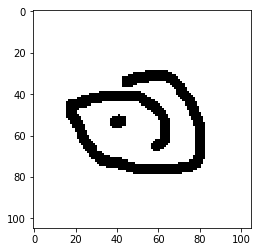

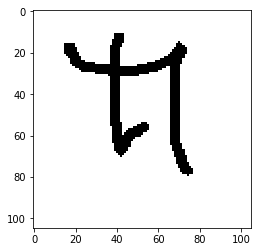

Distance 0.0
Distance 1.9464946780762098


In [23]:
def load_img_as_points(fn, show=False, inked=False): 
    """
    Load image file and return coordinates of 'inked' pixels in the binary image 
        Output:
            D : [n x 2] rows are coordinates
    """
    I = plt.imread(fn)
    I = np.array(I,dtype=bool)

    if inked:
        I = np.logical_not(I)
        (row,col) = I.nonzero()
        I = I[row.min():row.max(),col.min():col.max()]
        I = np.logical_not(I)

    if show:
        plt.imshow(I, cmap="gray")
        plt.show()

    return I


def test_load_img_as_points():
    img1 = load_img_as_points(os.path.join(DATASET, "one-shot-classification/run01/training/class01.png"))
    plt.imshow(img1, cmap="gray")
    plt.show()
    
    img2 = load_img_as_points(os.path.join(DATASET, "one-shot-classification/run01/training/class02.png"))
    plt.imshow(img2, cmap="gray")
    plt.show()    
    
    print("Distance", mod_hausdorff_distance(img1, img1))
    print("Distance", mod_hausdorff_distance(img1, img2))

test_load_img_as_points()

In [52]:
def classification_run(folder,f_load,f_cost,ftype='cost'):
    # Compute error rate for one run of one-shot classification
    #
    # Input
    #  folder : contains images for a run of one-shot classification
    #  f_load : itemA = f_load('file.png') should read in the image file and process it
    #  f_cost : f_cost(itemA,itemB) should compute similarity between two images, using output of f_load
    #  ftype  : 'cost' if small values from f_cost mean more similar, or 'score' if large values are more similar
    #
    # Output
    #  perror : percent errors (0 to 100% error)
    #
    fname_label = 'class_labels.txt' # where class labels are stored for each run
    assert ((ftype=='cost') | (ftype=='score'))

    base_folder = os.path.join(DATASET, "one-shot-classification")
    sub_folder = os.path.join(base_folder, folder)
    
    # get file names
    with open(os.path.join(sub_folder, fname_label), "r") as f:
        content = f.read().splitlines()
    
    pairs = [line.split() for line in content]
    test_files  = [os.path.join(base_folder, pair[0]) for pair in pairs]
    train_files = [os.path.join(base_folder, pair[1]) for pair in pairs]
    answers_files = copy.copy(train_files)
    test_files.sort()
    train_files.sort()
    ntrain = len(train_files)
    ntest = len(test_files)
    
    # load the images (and, if needed, extract features)
    train_items = [f_load(f) for f in train_files]
    test_items  = [f_load(f) for f in test_files ]

    # compute cost matrix
    costM = np.zeros((ntest,ntrain),float)
    for i in range(ntest):
        for c in range(ntrain):
            costM[i,c] = f_cost(test_items[i],train_items[c])

    if ftype == 'cost':
        YHAT = np.argmin(costM,axis=1)
    elif ftype == 'score':
        YHAT = np.argmax(costM,axis=1)
    else:
        assert False
        
    # compute the error rate
    correct = 0.0
    for i in range(ntest):
        if train_files[YHAT[i]] == answers_files[i]:
            correct += 1.0
    pcorrect = 100 * correct / ntest
    perror = 100 - pcorrect

    return perror

##  Percentage of error with a simple dist

In [57]:
def run_one_shot_classificaion_with_hausdorff_distance():
    nrun = 20 # number of classification runs
    fname_label = 'class_labels.txt' # where class labels are stored for each run
    
    perror = np.zeros(nrun)
    for r in range(1, nrun+1):
        # Add 0 for number from 0 to 9 (2 -> 02)
        rs = '0' + str(r) if len(str(r)) == 1 else str(r)
        perror[r-1] = classification_run('run'+rs, load_img_as_points, mod_hausdorff_distance, 'cost')
    
    print("Percentage of error", np.mean(perror))

run_one_shot_classificaion_with_hausdorff_distance()

Percentage of error 81.25
